In [1]:
%matplotlib inline  

from matplotlib import pyplot as plt
import logging
import numpy as np
import cv2

First step is to convert the video to frames

In [2]:
#cap = cv2.VideoCapture('./video/Color_20150819_133002_712.m4v')

#if cap.isOpened():
#    ret, frame = cap.read()
#else:
#    ret = False

#i = 1
#while(ret):
#    ret, frame = cap.read()
#    cv2.imwrite(str(i) + '.jpg', frame)
#    i = i + 1

#cap.release()
#cv2.destroyAllWindows()

Prepare file list

In [3]:
import imutils
from skimage.feature import hog
from skimage import io, color, exposure

filelist = {
    './train/positive/1.jpg': 1,
    './train/positive/2.jpg': 1,
    './train/positive/3.jpg': 1,
    './train/negative/1.jpg': 0,
    './train/negative/2.jpg': 0,
    './train/negative/3.jpg': 0,
    './train/negative/4.jpg': 0,
    './train/negative/5.jpg': 0
}

In [4]:
def hog_desc_skimage(img_file):
    img = color.rgb2gray(io.imread(img_file))
    fd, hog_img = hog(img, orientations=8, pixels_per_cell=(12, 12),
                    cells_per_block=(1, 1), visualise=True)
    return fd

def hog(winSize):
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    return hog

In [48]:
files = filelist.keys()
label = [filelist[f] for f in files]
label = np.array(label).reshape(-1)

winSize = (64, 48)
h = hog(winSize)
data = [h.compute(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2GRAY)).reshape(-1) for f in files]

Generate pyramids for original images

Training data 

In [49]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
from sklearn import cross_validation

def estimated_classifier(data, label):
    tuned_params = [
        {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
    ]
    score = "f1"
    print "Tunning Parameters for %s" % score
    grid_search = GridSearchCV(SVC(C=1), tuned_params, scoring='%s' % score)
    grid_search.fit(data, label)
    print "Best parameters set found on development set:"
    print grid_search.best_params_
    print grid_search.best_score_
    return grid_search.best_estimator_

clf = estimated_classifier(data, label)
clf.fit(data, label)
joblib.dump(clf, './model/svmModel.pkl')

Tunning Parameters for f1
Best parameters set found on development set:
{'kernel': 'linear', 'C': 0.1}
1.0


['./model/svmModel.pkl',
 './model/svmModel.pkl_01.npy',
 './model/svmModel.pkl_02.npy',
 './model/svmModel.pkl_03.npy',
 './model/svmModel.pkl_04.npy',
 './model/svmModel.pkl_05.npy',
 './model/svmModel.pkl_06.npy',
 './model/svmModel.pkl_07.npy',
 './model/svmModel.pkl_08.npy',
 './model/svmModel.pkl_09.npy',
 './model/svmModel.pkl_10.npy',
 './model/svmModel.pkl_11.npy']

In [82]:
def sliding_window(image, stepSize, windowSize):
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            right = image.shape[1] -1 if x + windowSize[0] >= image.shape[1] else x + windowSize[0]
            bottom = image.shape[0] - 1 if y + windowSize[1] >= image.shape[0] else y + windowSize[1]
            #print (bottom, right)
            yield (x, y, image[y:bottom, x:right])

def pyramid(image, scale=1.5, minSize=(32, 32)):
    yield image.copy()
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=min(512, w))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image.copy()

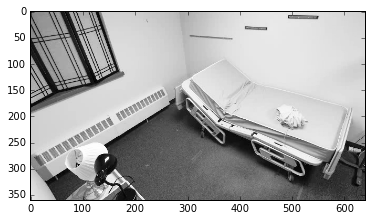

In [83]:
img = cv2.imread('./test/1.jpg')
test_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img, cmap='Greys_r')

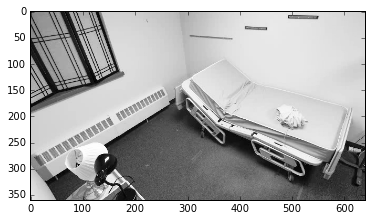

In [84]:
def add_bounding_box(img, points, winSize):
    for upleft in points:
        bottomright = (upleft[0]+winSize[0], upleft[1]+winSize[1])
        color = (0, 55, 255)
        cv2.rectangle(img, upleft, bottomright, color, +2, 4)
    return img

plt.imshow(test_img, cmap='Greys_r')

In [87]:
for img in pyramid(test_img):
    locations = []
    X = []
    for (loc_x,loc_y,window) in sliding_window(img, 8, winSize):
        if window.shape[0] != winSize[1] or window.shape[1] != winSize[0]:
            continue
        desc = h.compute(window).reshape(-1)
        X.append(desc)
        locations.append((loc_x, loc_y))

    if (len(X) > 0):
        Y = clf.predict(X)
        points = [locations[i] for i, y in enumerate(Y) if y == 1]
        img = add_bounding_box(img, points, winSize)
        cv2.imwrite('./predict/img_%d_%d.jpg' % (img.shape[1], img.shape[0]), img)
